<a href="https://colab.research.google.com/github/bjoernwe/safe_and_sound_protocol/blob/master/Safe_and_Sound_Protocol.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Safe and Sound Protocol

**Abstract:** This notebook modulates the frequencies of a given audio file in a way that is similar to the Safe and Sound Protocol (SPP).

**Background:** The [Safe and Sound Protocol](https://integratedlistening.com/ssp-safe-sound-protocol/) is a therapeutic treatment protocol based on [Polyvagal Theory](https://en.wikipedia.org/wiki/Polyvagal_theory) that has application in autism treatment and trauma therapy. Its basic idea is to exercise the middle-ear muscles to increase their capacity of filtering out low frequency sounds and tune into higher frequencies - which in turn can support reaching or maintining a physiological state of safety.

**Scope:** _This is a purely private code project that allows me to look into the science of SPP more closely. Note that beyond this scope, SPP is based on patented ideas and its commercial availability is restricted to licenced professionals._


# Implementation

The basic idea is to take a piece of (vocal) music and filter its frequencies to a range to which the middle-ear muscles are tuned to in a state of physiological state of safety. To exercise the middle-ear muscles further, the range of these frequencies is varied over time. That is, the frequency range varies during the track itself and the variations are further increased from day to day during the treatment protocol.

Examples from the patent of minimum and maximum frequencies during treatment days one and two:

[![Example of frequency modulation](https://patentimages.storage.googleapis.com/bf/7f/33/36f5e0b2a961c4/US10029068-20180724-D00005.png)](https://patents.google.com/patent/US10029068B2/)

The following code implemts some classes that allow to generate such bandpass filters of varying width and apply them to a WAV file. If you want to start reading the code, skip this chapter and start with the last one.

## Imports

In [0]:
import glob
import google.colab.drive
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy.io.wavfile
import scipy.signal
import seaborn

## Generation of modulated frequency bands

While a usually frequency band may be defined through a simple tuple `(min_freq, max_freq)`, for SPP we need a list of frequency bands that vary over time.

In [0]:
class SafeAndSoundModulatedBandGenerator():

    PRESETS = {
        'SSP_DAY_1' : {'smallest_band_min_max': (900, 1500),
                       'largest_band_min_max': (600, 2500),
                       'successive_band_widenings': [.33, .33, .66, .66, .33, .66, 1, .66, .33, .66, 1, .66, .33]},
        'SSP_DAY_2' : {'smallest_band_min_max': (900, 1500),
                       'largest_band_min_max': (600, 3500),
                       'successive_band_widenings': [.25, .5, .5, .75, .75, 1, .75, .5, .75, 1]}
    }

    def __init__(self, successive_band_widenings=[.33, .66, 1], smallest_band_min_max=(900, 1500), largest_band_min_max=(600, 2500)):
        self.successive_band_widenings = successive_band_widenings
        self.smallest_band_min_max = smallest_band_min_max
        self.largest_band_min_max = largest_band_min_max
        self._assert_input_validity()
        self.min_max_frequency_pairs = self._generate_sequence_of_band_frequency_pairs()
        self.frequency_band = CosineStepFrequencyBand(min_max_frequency_pairs=self.min_max_frequency_pairs)

    def _assert_input_validity(self):
        smallest_band_min, smallest_band_max = self.smallest_band_min_max
        largest_band_min, largest_band_max = self.largest_band_min_max
        assert(smallest_band_min < smallest_band_max)
        assert(largest_band_min < largest_band_max)
        assert(smallest_band_min >= largest_band_min)
        assert(smallest_band_max <= largest_band_max)

    def _generate_sequence_of_band_frequency_pairs(self):
        maximum_lower_band_widening = self.smallest_band_min_max[0] - self.largest_band_min_max[0]
        maximum_upper_band_widening = self.largest_band_min_max[1] - self.smallest_band_min_max[1]
        min_max_frequency_pairs = [self.smallest_band_min_max]
        for next_band_widening in self.successive_band_widenings:
            next_lower_limit = int(self.smallest_band_min_max[0] - next_band_widening * maximum_lower_band_widening)
            next_upper_limit = int(self.smallest_band_min_max[1] + next_band_widening * maximum_upper_band_widening)
            min_max_frequency_pairs.append((next_lower_limit, next_upper_limit))
            min_max_frequency_pairs.append(self.smallest_band_min_max)
        return min_max_frequency_pairs

    def get_min_and_max_values(self, number_of_steps):
        return self.frequency_band.get_min_and_max_values(number_of_steps)


class CosineStepFrequencyBand:

    def __init__(self, min_max_frequency_pairs):
        self._freq_band_lower_limits = np.array([], dtype=np.float)
        self._freq_band_upper_limits = np.array([], dtype=np.float)
        self._generate_limits_of_freq_band(min_max_frequency_pairs)

    def _generate_limits_of_freq_band(self, min_max_frequency_pairs):
        number_of_min_max_pairs = len(min_max_frequency_pairs)
        for i, min_max_frequency_pair in enumerate(min_max_frequency_pairs):
            next_min_max_frequency_pair = min_max_frequency_pairs[(i+1)%number_of_min_max_pairs]
            self._generate_next_cosine_step_in_band(from_min_max=min_max_frequency_pair, to_min_max=next_min_max_frequency_pair)
    
    def _generate_next_cosine_step_in_band(self, from_min_max, to_min_max):
        from_value_low, from_value_high = from_min_max
        to_value_low, to_value_high = to_min_max
        next_cosine_step_upper_limit = CosineStepFrequencyBand._generate_cosine_step(from_value=from_value_high, to_value=to_value_high)
        next_cosine_step_lower_limit = CosineStepFrequencyBand._generate_cosine_step(from_value=from_value_low,  to_value=to_value_low, number_of_steps=len(next_cosine_step_upper_limit))
        self._freq_band_lower_limits = np.append(self._freq_band_lower_limits, next_cosine_step_lower_limit)
        self._freq_band_upper_limits = np.append(self._freq_band_upper_limits, next_cosine_step_upper_limit)

    def _generate_cosine_step(from_value, to_value, number_of_steps=None):
        is_downward_step = False
        if from_value > to_value:
            from_value, to_value, is_downward_step = to_value, from_value, True
        step_height = to_value - from_value
        assert (step_height >= 0)
        if not number_of_steps:
            number_of_steps = int(step_height/25)
        unscaled_cosine_step = CosineStepFrequencyBand._generate_cosine_step_from_zero_to_one(number_of_steps, reverse=is_downward_step)
        scaled_cosine_step = (step_height * unscaled_cosine_step) + from_value
        assert(len(scaled_cosine_step) == number_of_steps)
        return scaled_cosine_step

    def _generate_cosine_step_from_zero_to_one(number_of_steps, reverse=False):
        swapped_sign = 1 if reverse else -1
        return swapped_sign * np.cos(np.linspace(0, np.pi, num=number_of_steps)) / 2. + .5

    def get_min_and_max_values(self, number_of_steps):
        result_lower_limits = np.array([], dtype=float)
        result_upper_limits = np.array([], dtype=float)
        while (len(result_lower_limits) < number_of_steps):
            result_lower_limits = np.append(result_lower_limits, self._freq_band_lower_limits)
            result_upper_limits = np.append(result_upper_limits, self._freq_band_upper_limits)
        return np.vstack([result_lower_limits, result_upper_limits])[:number_of_steps].T

### Plot example of frequency bands

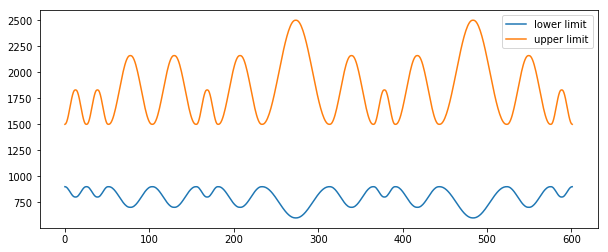

In [0]:
safe_and_sound_preset = SafeAndSoundModulatedBandGenerator.PRESETS['SSP_DAY_1']
safe_and_sound_band_generator = SafeAndSoundModulatedBandGenerator(**safe_and_sound_preset)
freq_band_min_max_values = safe_and_sound_band_generator.get_min_and_max_values(number_of_steps=500)

plt.figure(figsize=(10,4))
plt.plot(freq_band_min_max_values)
plt.legend(['lower limit', 'upper limit'], loc=1)

## Band-Pass filtering

Band-pass filtering is implemented by taking a list of varying frequency bands and turning them into a filter mask. That is, an array that contains zeros for frequencies to be filtered out and ones for frequencies to be kept. The WAV then can be transformed into the frequency domain through an STFT transformation and multiplied with the filter mask.

In [0]:
class BandpassFilterGenerator:

    def __init__(self, filter_shape, min_max_frequency_pairs):
        self._number_of_filters, self._width_of_filters = filter_shape
        self._min_max_frequency_pairs = min_max_frequency_pairs
        assert(len(min_max_frequency_pairs) >= self._number_of_filters)
        self._filter = self._calculate_filter()

    def _calculate_filter(self):
        raise NotImplementedError()

    def get_filter_mask(self):
        return self._filter


class BinaryBandpassFilterGenerator(BandpassFilterGenerator):

    def __init__(self, filter_shape, min_max_frequency_pairs):
        super().__init__(filter_shape, min_max_frequency_pairs)

    def _calculate_filter(self):
        filter = np.zeros((self._number_of_filters, self._width_of_filters))
        for t in range(self._number_of_filters):
            freq_band_min, freq_band_max = self._min_max_frequency_pairs[t]
            freq_band_min, freq_band_max = int(freq_band_min), int(freq_band_max)
            filter[t,freq_band_min:freq_band_max] = 1
        return filter


class ButterworthBandpassFilterGenerator(BandpassFilterGenerator):

    def __init__(self, filter_shape, min_max_frequency_pairs, sample_rate):
        self._sample_rate = sample_rate
        super().__init__(filter_shape, min_max_frequency_pairs)

    def _calculate_filter(self):
        filter = np.zeros((self._number_of_filters, self._width_of_filters))
        for t in range(self._number_of_filters):
            freq_band_min, freq_band_max = self._min_max_frequency_pairs[t]
            freq_band_min, freq_band_max = int(freq_band_min), int(freq_band_max)
            filter[t,1:] = self._butter_bandpass(freq_band_min, freq_band_max)
        return filter

    def _butter_bandpass(self, lowcut, highcut, order=5):
        """
        Source: https://stackoverflow.com/questions/12093594/how-to-implement-band-pass-butterworth-filter-with-scipy-signal-butter
        """
        nyq = 0.5 * self._sample_rate
        low = lowcut / nyq
        high = highcut / nyq
        b, a = scipy.signal.butter(order, [low, high], btype='band')
        _, h = scipy.signal.freqz(b, a, worN=self._sample_rate//2)
        return np.abs(h)

### Plot example of filter mask

First run the plotting example above.

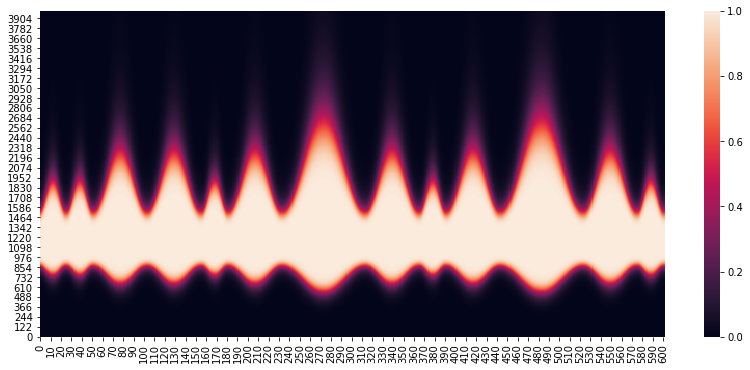

In [0]:
number_of_frequencies = 22051
number_of_stfts = len(freq_band_min_max_values)
filter = ButterworthBandpassFilter(filter_shape=(number_of_stfts, number_of_frequencies), 
                                   min_max_frequency_pairs=freq_band_min_max_values,
                                   sample_rate=44100).get_filter()
plt.figure(figsize=(14,6))
seaborn.heatmap(filter[:,:4000].T)
plt.gca().invert_yaxis()

## Short-Time Fourier Transform (STFT)

In [0]:
class STFT:

    def __init__(self, wav_data, sample_rate):
        self._wav_data = wav_data
        self._sample_rate = sample_rate
        self._stfts = self._calculate_stfts()

    def _calculate_stfts(self):
        _, _, Zxx = scipy.signal.stft(x=self._wav_data, fs=self._sample_rate, window='hanning', nperseg=self._sample_rate)
        return Zxx.T

    def get_number_of_stfts(self):
        return self._stfts.shape[0]

    def get_number_of_frequencies(self):
        return self._stfts.shape[1]

    def get_stfts(self):
        return self._stfts

    def apply_filter_mask(self, filter_mask):
        adjusted_filter_mask = self._adjust_filter_mask_for_loudness(filter_mask=filter_mask)
        self._stfts = np.multiply(self._stfts, adjusted_filter_mask)

    def _adjust_filter_mask_for_loudness(self, filter_mask):
        # TODO: Needs better understanding of the relationship between power and loudness
        return filter_mask

    def calculate_back_to_wav(self):
        _, wav_data = scipy.signal.istft(Zxx=self._stfts.T, fs=self._sample_rate, window='hanning', nperseg=self._sample_rate)
        wav_data = np.array(wav_data, dtype=np.int16)
        return wav_data

## Input WAV file

In [0]:
class WavFile:

    def __init__(self, filename):
        self._filename = filename
        self._sample_rate, self._data = scipy.io.wavfile.read(input_filename, mmap=True)
        number_of_channels_in_wav = self._data.ndim
        if number_of_channels_in_wav >= 2:
            self._data = self._data[:,0]

    def get_filename(self):
        return self._filename

    def get_number_of_frames(self):
        return self._data.shape[0]

    def get_length_in_seconds(self):
        return self._data.shape[0] / self._sample_rate

    def get_sample_rate(self):
        return self._sample_rate

    def get_data(self):
        return self._data

## Access to Google Drive

In [0]:
class GDriveFileAccessor:

    MOUNT_DIR = '/content/gdrive'

    def __init__(self, base_path='./', file_extension='*'):
        self.base_path = base_path
        self.file_extension = file_extension
        google.colab.drive.mount(GDriveFileAccessor.MOUNT_DIR, force_remount=False)

    def print_file_list(self):
        files = self.get_file_list()
        if files:
            print('\n'.join(['%d : %s' % (i, file) for i, file in enumerate(files)]))

    def get_file_list(self):
        files = glob.glob(f'{GDriveFileAccessor.MOUNT_DIR}/My Drive/{self.base_path}/{self.file_extension}')
        return files

# SPP-Modulation of a WAV file

## Implementation of the Modulation Process

Here is the high-level code that runs to the whole processing of modulating a WAV file.

To understand the code you may want to start reading here.

In [0]:
class SafeAndSoundWavModulator:

    def __init__(self, wav_filename, preset_name='SAS_DAY_1'):
        self._wav_filename = wav_filename
        self._preset_name = preset_name
        self._wav_file = self._read_wav_file()
        self._stft = self._calc_stft()
        self._filter_mask = self._calc_filter_mask()
        self._filtered_stft = self._calc_filtered_stft()
        self._modulated_wav = self._calc_modulated_wav()
        self._wav_output_filename = self._calc_wav_output_filename()
        self._write_modulated_wav_to_disk()

    def _read_wav_file(self):
        print('reading wav ...')
        return WavFile(filename=self._wav_filename)

    def _calc_stft(self):
        print('calculating STFT ...')
        wav_data = self._wav_file.get_data()
        sample_rate = self._wav_file.get_sample_rate()
        return STFT(wav_data=wav_data, sample_rate=sample_rate)
    
    def _calc_filter_mask(self):
        print('calculating filter mask ...')
        filter_shape = (self._stft.get_number_of_stfts(), self._stft.get_number_of_frequencies())
        freq_band_min_max_values = self._calc_freq_band_min_max_values()
        sample_rate = self._wav_file.get_sample_rate()
        butterworth_bandpass_filter = ButterworthBandpassFilter(filter_shape=filter_shape, 
                                                                min_max_frequency_pairs=freq_band_min_max_values,
                                                                sample_rate=sample_rate)
        filter_mask = butterworth_bandpass_filter.get_filter()
        return filter_mask
        
    def _calc_freq_band_min_max_values(self):
        print('calculating frequency bands ...')
        safe_and_sound_preset = SafeAndSoundModulatedBandGenerator.PRESETS[self._preset_name]
        safe_and_sound_band_generator = SafeAndSoundModulatedBandGenerator(**safe_and_sound_preset)
        number_of_steps = self._stft.get_number_of_stfts()
        return safe_and_sound_band_generator.get_min_and_max_values(number_of_steps=number_of_steps)

    def _calc_filtered_stft(self):
        print('applying filter mask ...')
        return self._stft.apply_filter_mask(filter_mask=self._filter_mask)

    def _calc_modulated_wav(self):
        print('calculating inverse STFT ...')
        return self._stft.calculate_back_to_wav()

    def _calc_wav_output_filename(self):
        return os.path.splitext(self._wav_filename)[0] + '_modulated.wav'

    def _write_modulated_wav_to_disk(self):
        print('writing wav ...')
        scipy.io.wavfile.write(filename=self._wav_output_filename, 
                               rate=self._wav_file.get_sample_rate(), 
                               data=self._modulated_wav)
        print(f'modulated wav written to {self._wav_output_filename}')

    def get_output_filename(self):
        return self._wav_output_filename

## Run the modulation process

### List available files from Google Drive

In [0]:
gdrive = GDriveFileAccessor(base_path='./Datasets/SafeAndSound', file_extension='*.wav')
gdrive.print_file_list()

### Process _i_-th File

In [0]:
file_index = 0
input_filename = gdrive.get_file_list()[file_index]
spp_modulator = SafeAndSoundWavModulator(wav_filename=input_filename)

reading wav ...
calculating STFT ...
calculating filter mask ...
calculating frequency bands ...
applying filter mask ...
calculating inverse STFT ...
writing wav ...
modulated wav written to /content/gdrive/My Drive/./Datasets/SafeAndSound/happy_modulated.wav
